In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_funciones_BBDD as sfbd
from src import soporte_sarima as ss
from src import soporte_temporales as st
from src import soporte_variables_poblacion as svp

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

In [5]:
df_poblacion = sfbd.dbeaver_fetch(sfbd.dbeaver_conexion("proyecto_final"),svp.query_poblacion)

In [6]:
df_poblacion.head()

,anio,poblacion
0,1960,3298021
1,1961,3408415
2,1962,3521164
3,1963,3635798
4,1964,3752313


In [7]:
df_poblacion.columns = ['FECHA', 'Población']
df_poblacion['FECHA'] = pd.to_datetime(df_poblacion['FECHA'].astype(str) + '-12-31')

In [8]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_poblacion, temporal_column="FECHA", value_column="Población")

analisis_st.exploracion_datos()

El número de filas es 64 y el número de columnas es 1

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Población,64,7329602,2443551,3298021,5203102,7352871,9432392,11332972


In [9]:
analisis_st.comprobar_serie_continua('A')

La serie temporal es continua para la frecuencia 'A', no faltan periodos.


In [10]:
analisis_st.graficar_serie()

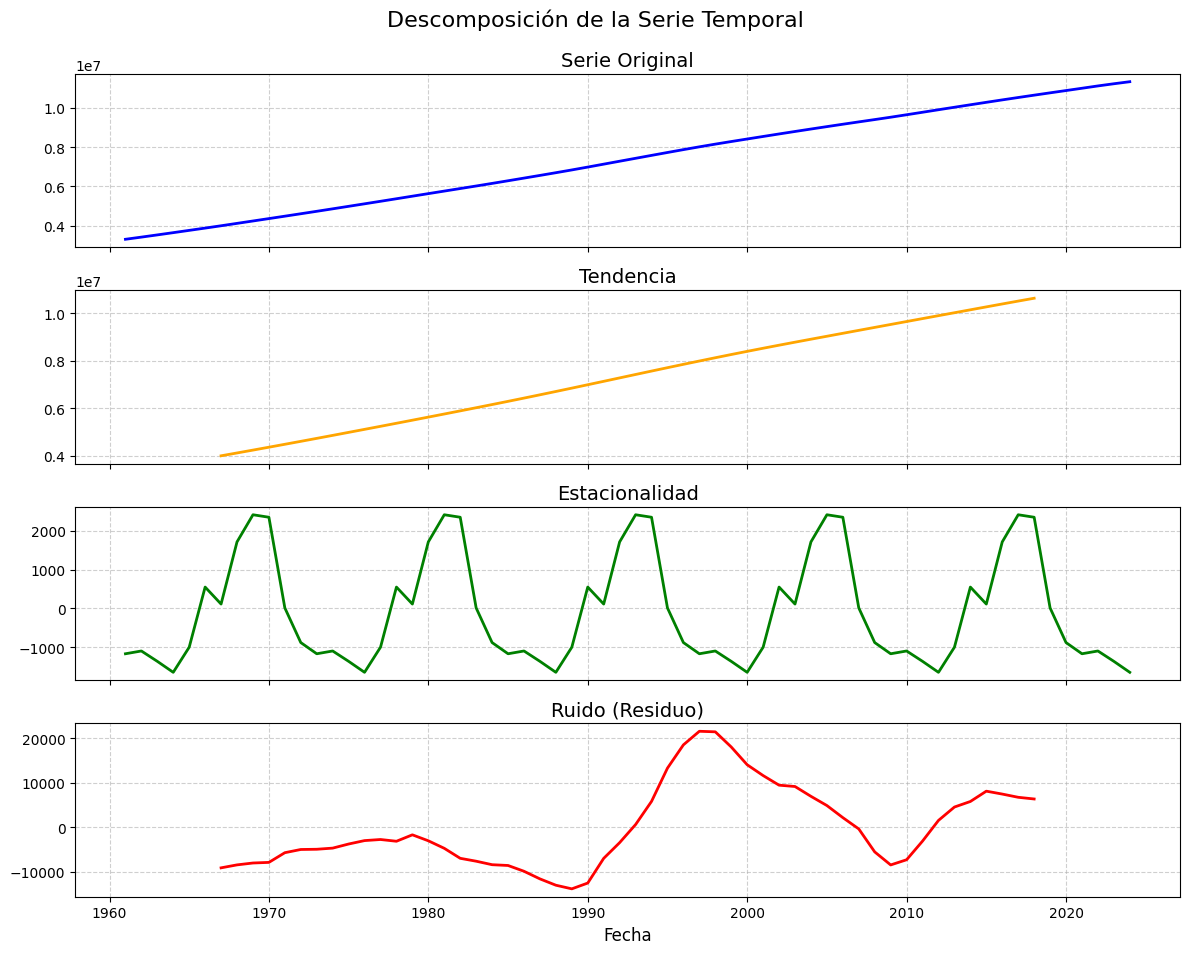

In [11]:
analisis_st.detectar_estacionalidad()

In [12]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -2.019568708932497
p-value: 0.27805935885765015
Valores Críticos:
1%: -3.552928203580539
5%: -2.9147306250000002
10%: -2.595137155612245
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


In [13]:
modelo_arima = st.ARIMAModel()

parametros_arima = modelo_arima.generar_parametros(p_range=range(1,6), q_range=range(1,6))
parametros_arima[:5]

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

In [14]:
train_size= int(0.7 * len(df_poblacion))
df_poblacion.set_index('FECHA', inplace=True)
df_poblacion.index = pd.to_datetime(df_poblacion.index)

y_train, y_test = df_poblacion[:train_size], df_poblacion[train_size:]

In [15]:
resultados_arima = modelo_arima.evaluar_modelos(y_train, y_test, parametros_arima, diferenciacion=1)
resultados_arima.head(3)

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\st

,p,q,RMSE
0,1,1,95902
1,1,2,99603
2,1,3,4155560


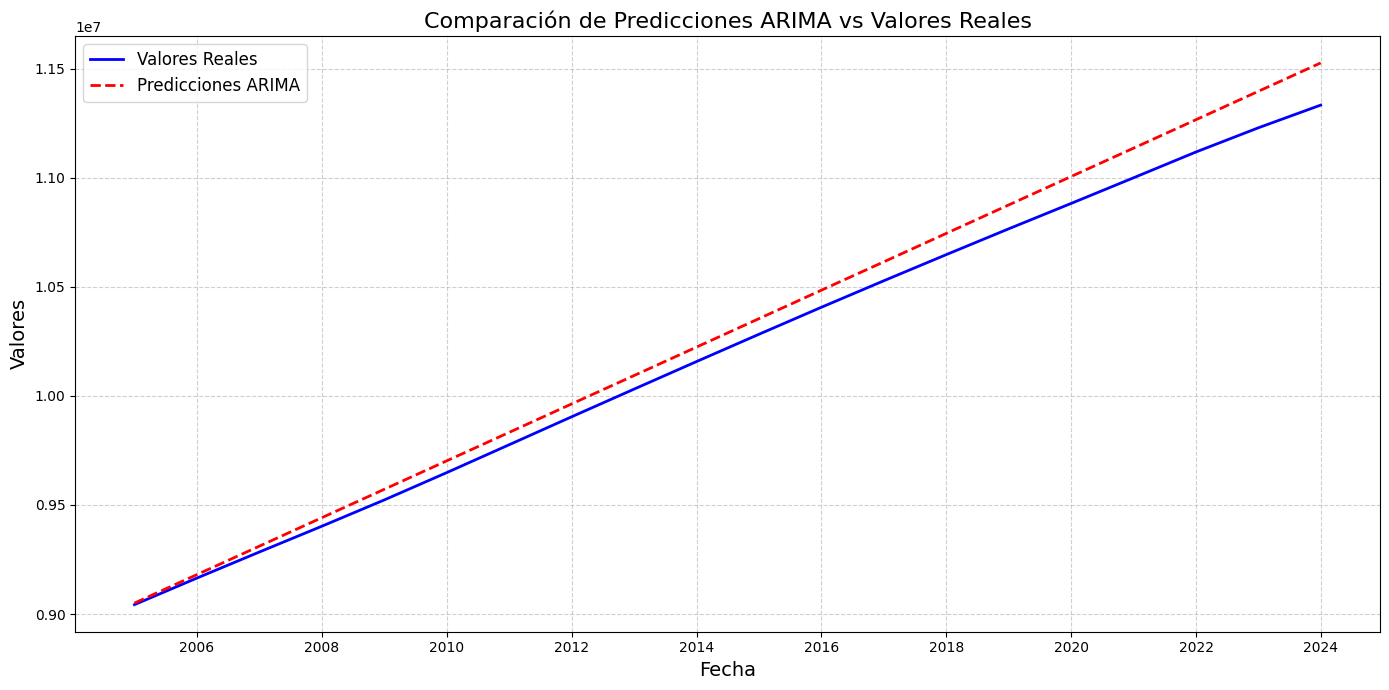

In [16]:
modelo_arima.visualizar_predicciones(y_test)

In [17]:
df_poblacion.reset_index(inplace=True)
df_poblacion.columns = ['ds', 'y']

In [18]:
df_poblacion.head()

,ds,y
0,1960-12-31,3298021
1,1961-12-31,3408415
2,1962-12-31,3521164
3,1963-12-31,3635798
4,1964-12-31,3752313


In [19]:
df_poblacion.tail()

,ds,y
59,2019-12-31,10881882
60,2020-12-31,10999664
61,2021-12-31,11117873
62,2022-12-31,11228821
63,2023-12-31,11332972


In [20]:
m = Prophet()
m.fit(df_poblacion)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=2, freq='Y') 
m.predict(future)

12:57:10 - cmdstanpy - INFO - Chain [1] start processing
12:57:10 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1960-12-31,207291,3289768,3303191,207291,207291,3089154,3089154,3089154,3089154,3089154,3089154,0,0,0,3296446
1,1961-12-31,321164,3402853,3415726,321164,321164,3087991,3087991,3087991,3087991,3087991,3087991,0,0,0,3409155
2,1962-12-31,435036,3514713,3528787,435036,435036,3086860,3086860,3086860,3086860,3086860,3086860,0,0,0,3521896
3,1963-12-31,548939,3628225,3641909,548939,548939,3086464,3086464,3086464,3086464,3086464,3086464,0,0,0,3635403
4,1964-12-31,663154,3745318,3759298,663154,663154,3089154,3089154,3089154,3089154,3089154,3089154,0,0,0,3752309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2021-12-31,8029613,11111271,11124237,8029613,8029613,3087991,3087991,3087991,3087991,3087991,3087991,0,0,0,11117604
62,2022-12-31,8150000,11230272,11243396,8150000,8150000,3086860,3086860,3086860,3086860,3086860,3086860,0,0,0,11236860
63,2023-12-31,8270387,11350019,11363140,8270387,8270387,3086464,3086464,3086464,3086464,3086464,3086464,0,0,0,11356851
64,2024-12-31,8391104,11473072,11487598,8390084,8392302,3089154,3089154,3089154,3089154,3089154,3089154,0,0,0,11480258


In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
61,2021-12-31,11117604,11111288,11124370
62,2022-12-31,11236860,11230785,11243598
63,2023-12-31,11356851,11350016,11363888
64,2024-12-31,11480258,11473368,11486797
65,2025-12-31,11599481,11590944,11608110


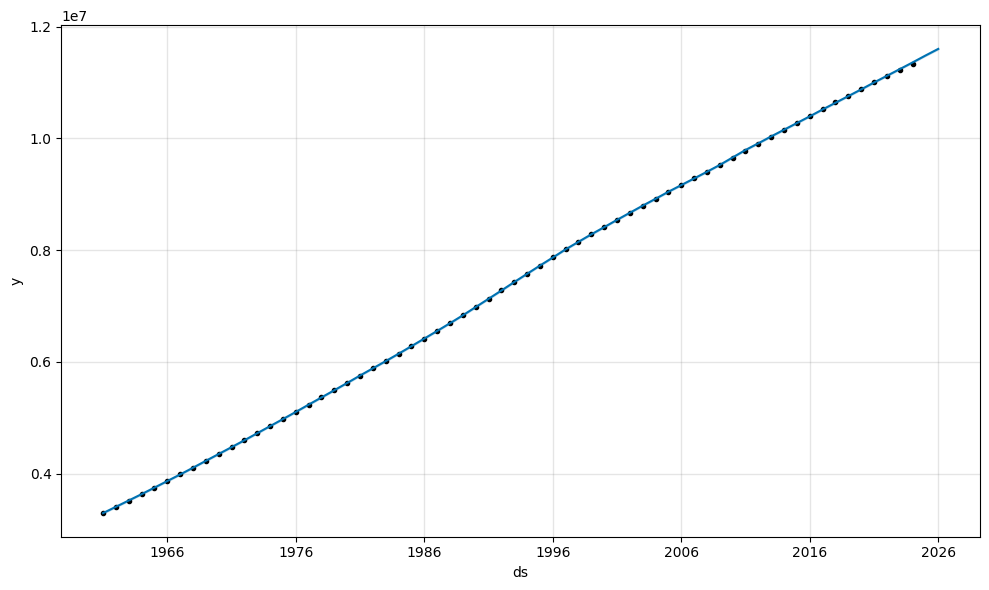

In [22]:
fig1 = m.plot(forecast)

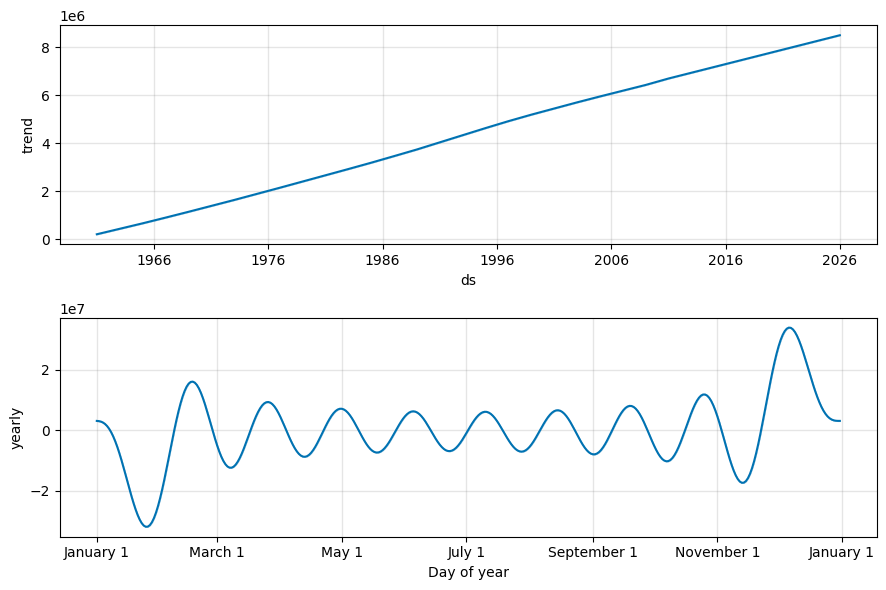

In [23]:
fig2 = m.plot_components(forecast)

In [24]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [25]:
plot_components_plotly(m, forecast)